<a href="https://colab.research.google.com/github/digs1998/Computer-Vision-Engineer-Task/blob/main/Object_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Centroid Based Tracker Class


In [1]:
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
import cv2
import datetime
import tensorflow as tf
from imutils.video import VideoStream

In [2]:
class CentroidTracker():
	def __init__(self, maxDisappeared=50):
		# initialize the next unique object ID along with two ordered
		# dictionaries used to keep track of mapping a given object
		# ID to its centroid and number of consecutive frames it has
		# been marked as "disappeared", respectively
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()

		# store the number of maximum consecutive frames a given
		# object is allowed to be marked as "disappeared" until we
		# need to deregister the object from tracking
		self.maxDisappeared = maxDisappeared

	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1

				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)

			# return early as there are no centroids or tracking info
			# to update
			return self.objects

		# initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype="int")

		# loop over the bounding box rectangles
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
			# use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

		# if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])

		# otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())

			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)

			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value as at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()

			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

			# in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()

			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue

				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0

				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)

			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)

			# in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1

					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)

			# otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])

		# return the set of trackable objects
		return self.objects

## Modifying MobileNet protofile

In [3]:
%%writefile /content/MobileNetSSD_deploy.prototxt

name: "MobileNet-SSD"
input: "data"
input_shape {
  dim: 1
  dim: 3
  dim: 300
  dim: 300
}
layer {
  name: "conv0"
  type: "Convolution"
  bottom: "data"
  top: "conv0"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 32
    pad: 1
    kernel_size: 3
    stride: 2
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv0/relu"
  type: "ReLU"
  bottom: "conv0"
  top: "conv0"
}
layer {
  name: "conv1/dw"
  type: "Convolution"
  bottom: "conv0"
  top: "conv1/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 32
    pad: 1
    kernel_size: 3
    group: 32
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv1/dw/relu"
  type: "ReLU"
  bottom: "conv1/dw"
  top: "conv1/dw"
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "conv1/dw"
  top: "conv1"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 64
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv1/relu"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "conv2/dw"
  type: "Convolution"
  bottom: "conv1"
  top: "conv2/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 64
    pad: 1
    kernel_size: 3
    stride: 2
    group: 64
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv2/dw/relu"
  type: "ReLU"
  bottom: "conv2/dw"
  top: "conv2/dw"
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "conv2/dw"
  top: "conv2"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 128
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv2/relu"
  type: "ReLU"
  bottom: "conv2"
  top: "conv2"
}
layer {
  name: "conv3/dw"
  type: "Convolution"
  bottom: "conv2"
  top: "conv3/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 128
    pad: 1
    kernel_size: 3
    group: 128
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv3/dw/relu"
  type: "ReLU"
  bottom: "conv3/dw"
  top: "conv3/dw"
}
layer {
  name: "conv3"
  type: "Convolution"
  bottom: "conv3/dw"
  top: "conv3"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 128
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv3/relu"
  type: "ReLU"
  bottom: "conv3"
  top: "conv3"
}
layer {
  name: "conv4/dw"
  type: "Convolution"
  bottom: "conv3"
  top: "conv4/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 128
    pad: 1
    kernel_size: 3
    stride: 2
    group: 128
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv4/dw/relu"
  type: "ReLU"
  bottom: "conv4/dw"
  top: "conv4/dw"
}
layer {
  name: "conv4"
  type: "Convolution"
  bottom: "conv4/dw"
  top: "conv4"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 256
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv4/relu"
  type: "ReLU"
  bottom: "conv4"
  top: "conv4"
}
layer {
  name: "conv5/dw"
  type: "Convolution"
  bottom: "conv4"
  top: "conv5/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 256
    pad: 1
    kernel_size: 3
    group: 256
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv5/dw/relu"
  type: "ReLU"
  bottom: "conv5/dw"
  top: "conv5/dw"
}
layer {
  name: "conv5"
  type: "Convolution"
  bottom: "conv5/dw"
  top: "conv5"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 256
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv5/relu"
  type: "ReLU"
  bottom: "conv5"
  top: "conv5"
}
layer {
  name: "conv6/dw"
  type: "Convolution"
  bottom: "conv5"
  top: "conv6/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 256
    pad: 1
    kernel_size: 3
    stride: 2
    group: 256
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv6/dw/relu"
  type: "ReLU"
  bottom: "conv6/dw"
  top: "conv6/dw"
}
layer {
  name: "conv6"
  type: "Convolution"
  bottom: "conv6/dw"
  top: "conv6"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv6/relu"
  type: "ReLU"
  bottom: "conv6"
  top: "conv6"
}
layer {
  name: "conv7/dw"
  type: "Convolution"
  bottom: "conv6"
  top: "conv7/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    pad: 1
    kernel_size: 3
    group: 512
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv7/dw/relu"
  type: "ReLU"
  bottom: "conv7/dw"
  top: "conv7/dw"
}
layer {
  name: "conv7"
  type: "Convolution"
  bottom: "conv7/dw"
  top: "conv7"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv7/relu"
  type: "ReLU"
  bottom: "conv7"
  top: "conv7"
}
layer {
  name: "conv8/dw"
  type: "Convolution"
  bottom: "conv7"
  top: "conv8/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    pad: 1
    kernel_size: 3
    group: 512
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv8/dw/relu"
  type: "ReLU"
  bottom: "conv8/dw"
  top: "conv8/dw"
}
layer {
  name: "conv8"
  type: "Convolution"
  bottom: "conv8/dw"
  top: "conv8"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv8/relu"
  type: "ReLU"
  bottom: "conv8"
  top: "conv8"
}
layer {
  name: "conv9/dw"
  type: "Convolution"
  bottom: "conv8"
  top: "conv9/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    pad: 1
    kernel_size: 3
    group: 512
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv9/dw/relu"
  type: "ReLU"
  bottom: "conv9/dw"
  top: "conv9/dw"
}
layer {
  name: "conv9"
  type: "Convolution"
  bottom: "conv9/dw"
  top: "conv9"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv9/relu"
  type: "ReLU"
  bottom: "conv9"
  top: "conv9"
}
layer {
  name: "conv10/dw"
  type: "Convolution"
  bottom: "conv9"
  top: "conv10/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    pad: 1
    kernel_size: 3
    group: 512
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv10/dw/relu"
  type: "ReLU"
  bottom: "conv10/dw"
  top: "conv10/dw"
}
layer {
  name: "conv10"
  type: "Convolution"
  bottom: "conv10/dw"
  top: "conv10"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv10/relu"
  type: "ReLU"
  bottom: "conv10"
  top: "conv10"
}
layer {
  name: "conv11/dw"
  type: "Convolution"
  bottom: "conv10"
  top: "conv11/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    pad: 1
    kernel_size: 3
    group: 512
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv11/dw/relu"
  type: "ReLU"
  bottom: "conv11/dw"
  top: "conv11/dw"
}
layer {
  name: "conv11"
  type: "Convolution"
  bottom: "conv11/dw"
  top: "conv11"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv11/relu"
  type: "ReLU"
  bottom: "conv11"
  top: "conv11"
}
layer {
  name: "conv12/dw"
  type: "Convolution"
  bottom: "conv11"
  top: "conv12/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    pad: 1
    kernel_size: 3
    stride: 2
    group: 512
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv12/dw/relu"
  type: "ReLU"
  bottom: "conv12/dw"
  top: "conv12/dw"
}
layer {
  name: "conv12"
  type: "Convolution"
  bottom: "conv12/dw"
  top: "conv12"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 1024
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv12/relu"
  type: "ReLU"
  bottom: "conv12"
  top: "conv12"
}
layer {
  name: "conv13/dw"
  type: "Convolution"
  bottom: "conv12"
  top: "conv13/dw"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 1024
    pad: 1
    kernel_size: 3
    group: 1024
    engine: CAFFE
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv13/dw/relu"
  type: "ReLU"
  bottom: "conv13/dw"
  top: "conv13/dw"
}
layer {
  name: "conv13"
  type: "Convolution"
  bottom: "conv13/dw"
  top: "conv13"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 1024
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv13/relu"
  type: "ReLU"
  bottom: "conv13"
  top: "conv13"
}
layer {
  name: "conv14_1"
  type: "Convolution"
  bottom: "conv13"
  top: "conv14_1"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 256
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv14_1/relu"
  type: "ReLU"
  bottom: "conv14_1"
  top: "conv14_1"
}
layer {
  name: "conv14_2"
  type: "Convolution"
  bottom: "conv14_1"
  top: "conv14_2"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 512
    pad: 1
    kernel_size: 3
    stride: 2
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv14_2/relu"
  type: "ReLU"
  bottom: "conv14_2"
  top: "conv14_2"
}
layer {
  name: "conv15_1"
  type: "Convolution"
  bottom: "conv14_2"
  top: "conv15_1"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 128
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv15_1/relu"
  type: "ReLU"
  bottom: "conv15_1"
  top: "conv15_1"
}
layer {
  name: "conv15_2"
  type: "Convolution"
  bottom: "conv15_1"
  top: "conv15_2"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 256
    pad: 1
    kernel_size: 3
    stride: 2
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv15_2/relu"
  type: "ReLU"
  bottom: "conv15_2"
  top: "conv15_2"
}
layer {
  name: "conv16_1"
  type: "Convolution"
  bottom: "conv15_2"
  top: "conv16_1"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 128
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv16_1/relu"
  type: "ReLU"
  bottom: "conv16_1"
  top: "conv16_1"
}
layer {
  name: "conv16_2"
  type: "Convolution"
  bottom: "conv16_1"
  top: "conv16_2"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 256
    pad: 1
    kernel_size: 3
    stride: 2
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv16_2/relu"
  type: "ReLU"
  bottom: "conv16_2"
  top: "conv16_2"
}
layer {
  name: "conv17_1"
  type: "Convolution"
  bottom: "conv16_2"
  top: "conv17_1"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 64
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv17_1/relu"
  type: "ReLU"
  bottom: "conv17_1"
  top: "conv17_1"
}
layer {
  name: "conv17_2"
  type: "Convolution"
  bottom: "conv17_1"
  top: "conv17_2"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 128
    pad: 1
    kernel_size: 3
    stride: 2
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv17_2/relu"
  type: "ReLU"
  bottom: "conv17_2"
  top: "conv17_2"
}
layer {
  name: "conv11_mbox_loc"
  type: "Convolution"
  bottom: "conv11"
  top: "conv11_mbox_loc"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 12
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv11_mbox_loc_perm"
  type: "Permute"
  bottom: "conv11_mbox_loc"
  top: "conv11_mbox_loc_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv11_mbox_loc_flat"
  type: "Flatten"
  bottom: "conv11_mbox_loc_perm"
  top: "conv11_mbox_loc_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv11_mbox_conf"
  type: "Convolution"
  bottom: "conv11"
  top: "conv11_mbox_conf"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 63
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv11_mbox_conf_perm"
  type: "Permute"
  bottom: "conv11_mbox_conf"
  top: "conv11_mbox_conf_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv11_mbox_conf_flat"
  type: "Flatten"
  bottom: "conv11_mbox_conf_perm"
  top: "conv11_mbox_conf_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv11_mbox_priorbox"
  type: "PriorBox"
  bottom: "conv11"
  bottom: "data"
  top: "conv11_mbox_priorbox"
  prior_box_param {
    min_size: 60.0
    aspect_ratio: 2.0
    flip: true
    clip: false
    variance: 0.1
    variance: 0.1
    variance: 0.2
    variance: 0.2
    offset: 0.5
  }
}
layer {
  name: "conv13_mbox_loc"
  type: "Convolution"
  bottom: "conv13"
  top: "conv13_mbox_loc"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 24
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv13_mbox_loc_perm"
  type: "Permute"
  bottom: "conv13_mbox_loc"
  top: "conv13_mbox_loc_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv13_mbox_loc_flat"
  type: "Flatten"
  bottom: "conv13_mbox_loc_perm"
  top: "conv13_mbox_loc_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv13_mbox_conf"
  type: "Convolution"
  bottom: "conv13"
  top: "conv13_mbox_conf"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 126
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv13_mbox_conf_perm"
  type: "Permute"
  bottom: "conv13_mbox_conf"
  top: "conv13_mbox_conf_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv13_mbox_conf_flat"
  type: "Flatten"
  bottom: "conv13_mbox_conf_perm"
  top: "conv13_mbox_conf_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv13_mbox_priorbox"
  type: "PriorBox"
  bottom: "conv13"
  bottom: "data"
  top: "conv13_mbox_priorbox"
  prior_box_param {
    min_size: 105.0
    max_size: 150.0
    aspect_ratio: 2.0
    aspect_ratio: 3.0
    flip: true
    clip: false
    variance: 0.1
    variance: 0.1
    variance: 0.2
    variance: 0.2
    offset: 0.5
  }
}
layer {
  name: "conv14_2_mbox_loc"
  type: "Convolution"
  bottom: "conv14_2"
  top: "conv14_2_mbox_loc"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 24
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv14_2_mbox_loc_perm"
  type: "Permute"
  bottom: "conv14_2_mbox_loc"
  top: "conv14_2_mbox_loc_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv14_2_mbox_loc_flat"
  type: "Flatten"
  bottom: "conv14_2_mbox_loc_perm"
  top: "conv14_2_mbox_loc_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv14_2_mbox_conf"
  type: "Convolution"
  bottom: "conv14_2"
  top: "conv14_2_mbox_conf"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 126
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv14_2_mbox_conf_perm"
  type: "Permute"
  bottom: "conv14_2_mbox_conf"
  top: "conv14_2_mbox_conf_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv14_2_mbox_conf_flat"
  type: "Flatten"
  bottom: "conv14_2_mbox_conf_perm"
  top: "conv14_2_mbox_conf_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv14_2_mbox_priorbox"
  type: "PriorBox"
  bottom: "conv14_2"
  bottom: "data"
  top: "conv14_2_mbox_priorbox"
  prior_box_param {
    min_size: 150.0
    max_size: 195.0
    aspect_ratio: 2.0
    aspect_ratio: 3.0
    flip: true
    clip: false
    variance: 0.1
    variance: 0.1
    variance: 0.2
    variance: 0.2
    offset: 0.5
  }
}
layer {
  name: "conv15_2_mbox_loc"
  type: "Convolution"
  bottom: "conv15_2"
  top: "conv15_2_mbox_loc"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 24
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv15_2_mbox_loc_perm"
  type: "Permute"
  bottom: "conv15_2_mbox_loc"
  top: "conv15_2_mbox_loc_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv15_2_mbox_loc_flat"
  type: "Flatten"
  bottom: "conv15_2_mbox_loc_perm"
  top: "conv15_2_mbox_loc_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv15_2_mbox_conf"
  type: "Convolution"
  bottom: "conv15_2"
  top: "conv15_2_mbox_conf"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 126
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv15_2_mbox_conf_perm"
  type: "Permute"
  bottom: "conv15_2_mbox_conf"
  top: "conv15_2_mbox_conf_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv15_2_mbox_conf_flat"
  type: "Flatten"
  bottom: "conv15_2_mbox_conf_perm"
  top: "conv15_2_mbox_conf_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv15_2_mbox_priorbox"
  type: "PriorBox"
  bottom: "conv15_2"
  bottom: "data"
  top: "conv15_2_mbox_priorbox"
  prior_box_param {
    min_size: 195.0
    max_size: 240.0
    aspect_ratio: 2.0
    aspect_ratio: 3.0
    flip: true
    clip: false
    variance: 0.1
    variance: 0.1
    variance: 0.2
    variance: 0.2
    offset: 0.5
  }
}
layer {
  name: "conv16_2_mbox_loc"
  type: "Convolution"
  bottom: "conv16_2"
  top: "conv16_2_mbox_loc"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 24
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv16_2_mbox_loc_perm"
  type: "Permute"
  bottom: "conv16_2_mbox_loc"
  top: "conv16_2_mbox_loc_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv16_2_mbox_loc_flat"
  type: "Flatten"
  bottom: "conv16_2_mbox_loc_perm"
  top: "conv16_2_mbox_loc_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv16_2_mbox_conf"
  type: "Convolution"
  bottom: "conv16_2"
  top: "conv16_2_mbox_conf"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 126
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv16_2_mbox_conf_perm"
  type: "Permute"
  bottom: "conv16_2_mbox_conf"
  top: "conv16_2_mbox_conf_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv16_2_mbox_conf_flat"
  type: "Flatten"
  bottom: "conv16_2_mbox_conf_perm"
  top: "conv16_2_mbox_conf_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv16_2_mbox_priorbox"
  type: "PriorBox"
  bottom: "conv16_2"
  bottom: "data"
  top: "conv16_2_mbox_priorbox"
  prior_box_param {
    min_size: 240.0
    max_size: 285.0
    aspect_ratio: 2.0
    aspect_ratio: 3.0
    flip: true
    clip: false
    variance: 0.1
    variance: 0.1
    variance: 0.2
    variance: 0.2
    offset: 0.5
  }
}
layer {
  name: "conv17_2_mbox_loc"
  type: "Convolution"
  bottom: "conv17_2"
  top: "conv17_2_mbox_loc"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 24
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv17_2_mbox_loc_perm"
  type: "Permute"
  bottom: "conv17_2_mbox_loc"
  top: "conv17_2_mbox_loc_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv17_2_mbox_loc_flat"
  type: "Flatten"
  bottom: "conv17_2_mbox_loc_perm"
  top: "conv17_2_mbox_loc_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv17_2_mbox_conf"
  type: "Convolution"
  bottom: "conv17_2"
  top: "conv17_2_mbox_conf"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 126
    kernel_size: 1
    weight_filler {
      type: "msra"
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "conv17_2_mbox_conf_perm"
  type: "Permute"
  bottom: "conv17_2_mbox_conf"
  top: "conv17_2_mbox_conf_perm"
  permute_param {
    order: 0
    order: 2
    order: 3
    order: 1
  }
}
layer {
  name: "conv17_2_mbox_conf_flat"
  type: "Flatten"
  bottom: "conv17_2_mbox_conf_perm"
  top: "conv17_2_mbox_conf_flat"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "conv17_2_mbox_priorbox"
  type: "PriorBox"
  bottom: "conv17_2"
  bottom: "data"
  top: "conv17_2_mbox_priorbox"
  prior_box_param {
    min_size: 285.0
    max_size: 300.0
    aspect_ratio: 2.0
    aspect_ratio: 3.0
    flip: true
    clip: false
    variance: 0.1
    variance: 0.1
    variance: 0.2
    variance: 0.2
    offset: 0.5
  }
}
layer {
  name: "mbox_loc"
  type: "Concat"
  bottom: "conv11_mbox_loc_flat"
  bottom: "conv13_mbox_loc_flat"
  bottom: "conv14_2_mbox_loc_flat"
  bottom: "conv15_2_mbox_loc_flat"
  bottom: "conv16_2_mbox_loc_flat"
  bottom: "conv17_2_mbox_loc_flat"
  top: "mbox_loc"
  concat_param {
    axis: 1
  }
}
layer {
  name: "mbox_conf"
  type: "Concat"
  bottom: "conv11_mbox_conf_flat"
  bottom: "conv13_mbox_conf_flat"
  bottom: "conv14_2_mbox_conf_flat"
  bottom: "conv15_2_mbox_conf_flat"
  bottom: "conv16_2_mbox_conf_flat"
  bottom: "conv17_2_mbox_conf_flat"
  top: "mbox_conf"
  concat_param {
    axis: 1
  }
}
layer {
  name: "mbox_priorbox"
  type: "Concat"
  bottom: "conv11_mbox_priorbox"
  bottom: "conv13_mbox_priorbox"
  bottom: "conv14_2_mbox_priorbox"
  bottom: "conv15_2_mbox_priorbox"
  bottom: "conv16_2_mbox_priorbox"
  bottom: "conv17_2_mbox_priorbox"
  top: "mbox_priorbox"
  concat_param {
    axis: 2
  }
}
layer {
  name: "mbox_conf_reshape"
  type: "Reshape"
  bottom: "mbox_conf"
  top: "mbox_conf_reshape"
  reshape_param {
    shape {
      dim: 0
      dim: -1
      dim: 21
    }
  }
}
layer {
  name: "mbox_conf_softmax"
  type: "Softmax"
  bottom: "mbox_conf_reshape"
  top: "mbox_conf_softmax"
  softmax_param {
    axis: 2
  }
}
layer {
  name: "mbox_conf_flatten"
  type: "Flatten"
  bottom: "mbox_conf_softmax"
  top: "mbox_conf_flatten"
  flatten_param {
    axis: 1
  }
}
layer {
  name: "detection_out"
  type: "DetectionOutput"
  bottom: "mbox_loc"
  bottom: "mbox_conf_flatten"
  bottom: "mbox_priorbox"
  top: "detection_out"
  include {
    phase: TEST
  }
  detection_output_param {
    num_classes: 21
    share_location: true
    background_label_id: 0
    nms_param {
      nms_threshold: 0.45
      top_k: 100
    }
    code_type: CENTER_SIZE
    keep_top_k: 100
    confidence_threshold: 0.25
  }
}

Overwriting /content/MobileNetSSD_deploy.prototxt


## Instantiating Model

In [4]:
print("[INFO] loading model...")
protopath = "/content/MobileNetSSD_deploy.prototxt"
modelpath = "/content/MobileNetSSD_deploy.caffemodel"
net = cv2.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)

[INFO] loading model...


## Enabling WebCam access on Colab

In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


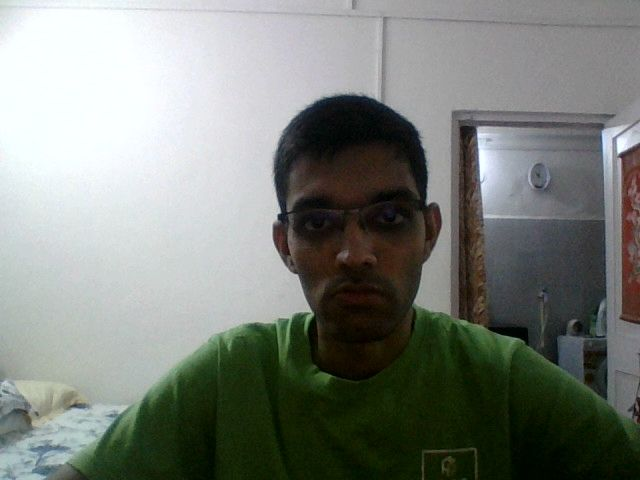

In [6]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Testing the Model

In [12]:

%%writefile object_tracker.py

import time
import imutils
from google.colab.patches import cv2_imshow

import argparse

ap = argparse.ArgumentParser()
ap.add_argument("--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = ap.parse_args()

ct = CentroidTracker()
(H, W) = (None, None)

print("[INFO] starting video stream...")
vs = cv2.imread('/content/photo.jpg')
time.sleep(2.0)
confidence = 0.75

# loop over the frames from the video stream
while True:
	# read the next frame from the video stream and resize it
	frame = vs
	frame = imutils.resize(frame, width=600)

	# if the frame dimensions are None, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# construct a blob from the frame, pass it through the network,
	# obtain our output predictions, and initialize the list of
	# bounding box rectangles
	blob = cv2.dnn.blobFromImage(frame, 1.0, (W, H),
		(104.0, 177.0, 123.0))
	net.setInput(blob)
	detections = net.forward()
	rects = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# filter out weak detections by ensuring the predicted
		# probability is greater than a minimum threshold
		if detections[0, 0, i, 2] > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the object, then update the bounding box rectangles list
			box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
			rects.append(box.astype("int"))

			# draw a bounding box surrounding the object so we can
			# visualize it
			(startX, startY, endX, endY) = box.astype("int")
			cv2.rectangle(frame, (startX, startY), (endX, endY),
				(0, 255, 0), 2)

	# update our centroid tracker using the computed set of bounding
	# box rectangles
	objects = ct.update(rects)

	# loop over the tracked objects
	for (objectID, centroid) in objects.items():
		# draw both the ID of the object and the centroid of the
		# object on the output frame
		text = "ID {}".format(objectID)
		cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
		cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

	# show the output frame
	cv2_imshow(frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

Writing object_tracker.py
